In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.

['test.csv', 'train.csv', 'sample_submission.csv']


In [2]:
# LOAD LIBRARIES
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, BatchNormalization,InputLayer,Conv2DTranspose
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import LearningRateScheduler

Using TensorFlow backend.


In [3]:
import matplotlib.pyplot as plt

%matplotlib inline

import numpy as np
import keras
from keras.datasets import mnist
from keras.models import Model, Sequential
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D, Flatten, Reshape
from keras import regularizers

In [4]:
# LOAD THE DATA
train = pd.read_csv("../input/train.csv")
test = pd.read_csv("../input/test.csv")
train.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [5]:
Y_train = train["label"]
X_train = train.drop(labels = ["label"],axis = 1)
X_train = X_train / 255.0
X_test = test / 255.0
X_train = X_train.values.reshape(-1,28,28,1)
X_test = X_test.values.reshape(-1,28,28,1)
X_train.shape,X_test.shape

((42000, 28, 28, 1), (28000, 28, 28, 1))

In [6]:
def train_val_split(x_train, y_train):
    rnd = np.random.RandomState(seed=42)
    perm = rnd.permutation(len(x_train))
    train_idx = perm[:int(0.8 * len(x_train))]
    val_idx = perm[int(0.8 * len(x_train)):]
    return x_train[train_idx], y_train[train_idx], x_train[val_idx], y_train[val_idx]

n = 20000  # for 2 random indices
index = np.random.choice(X_train.shape[0], n, replace=False) 
X_train=X_train[index]
x_train, y_train, x_val, y_val = train_val_split(X_train, X_train)

max_value = float(x_train.max())
x_train = x_train.astype('float32') / max_value
x_val = x_val.astype('float32') / max_value
print(x_train.shape, x_val.shape)

(16000, 28, 28, 1) (4000, 28, 28, 1)


In [7]:

input=Input(shape=(x_train.shape[1:]))
encoded=Conv2D(16, (3, 3), activation='relu', padding='same')(input)
encoded=MaxPooling2D((2, 2), padding='same')(encoded)
encoded=Conv2D(8, (3, 3), activation='relu', padding='same')(encoded)
encoded=MaxPooling2D((2, 2), padding='same')(encoded)
encoded=Conv2D(8, (3, 3), strides=(2,2), activation='relu', padding='same')(encoded)
encoded=Flatten()(encoded)

decoded=Reshape((4, 4, 8))(encoded)
decoded=Conv2D(8, (3, 3), activation='relu', padding='same')(decoded)
decoded=UpSampling2D((2, 2))(decoded)
decoded=Conv2D(8, (3, 3), activation='relu', padding='same')(decoded)
decoded=UpSampling2D((2, 2))(decoded)
decoded=Conv2D(16, (3, 3), activation='relu')(decoded)
decoded=UpSampling2D((2, 2))(decoded)
decoded=Conv2D(1, (3, 3), activation='sigmoid', padding='same')(decoded)
        
autoencoder=Model(input,decoded)


autoencoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 16)        160       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 14, 14, 8)         1160      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 7, 7, 8)           0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 4, 4, 8)           584       
_________________________________________________________________
flatten_1 (Flatten)          (None, 128)               0         
__________

In [8]:
x_train.shape

(16000, 28, 28, 1)

In [9]:
encoder = Model(inputs=autoencoder.input, outputs=autoencoder.layers[6].output)
encoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 16)        160       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 14, 14, 8)         1160      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 7, 7, 8)           0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 4, 4, 8)           584       
_________________________________________________________________
flatten_1 (Flatten)          (None, 128)               0         
Total para

In [10]:
encoded_input = Input(shape=(128,))

deco = autoencoder.layers[-8](encoded_input)
deco = autoencoder.layers[-7](deco)
deco = autoencoder.layers[-6](deco)
deco = autoencoder.layers[-5](deco)
deco = autoencoder.layers[-4](deco)
deco = autoencoder.layers[-3](deco)
deco = autoencoder.layers[-2](deco)
deco = autoencoder.layers[-1](deco)
# create the decoder model
decoder = Model(encoded_input, deco)
decoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 128)               0         
_________________________________________________________________
reshape_1 (Reshape)          (None, 4, 4, 8)           0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 4, 4, 8)           584       
_________________________________________________________________
up_sampling2d_1 (UpSampling2 (None, 8, 8, 8)           0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 8, 8, 8)           584       
_________________________________________________________________
up_sampling2d_2 (UpSampling2 (None, 16, 16, 8)         0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 14, 14, 16)        1168      
__________

In [11]:
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

In [12]:
len(autoencoder.layers),len(encoder.layers),len(decoder.layers)

(15, 7, 9)

In [13]:
from keras.preprocessing import image


In [14]:
gen = image.ImageDataGenerator()
batches = gen.flow(x_train, x_train, batch_size=64)
val_batches=gen.flow(x_val, x_val, batch_size=64)

In [15]:
history=autoencoder.fit_generator(generator=batches, steps_per_epoch=batches.n, epochs=4, 
                    validation_data=val_batches, validation_steps=val_batches.n)

Epoch 1/50
16000/16000 [==============================] - 116s 7ms/step - loss: 0.0958 - val_loss: 0.0847
Epoch 2/50
16000/16000 [==============================] - 112s 7ms/step - loss: 0.0827 - val_loss: 0.0815
Epoch 3/50
16000/16000 [==============================] - 113s 7ms/step - loss: 0.0805 - val_loss: 0.0801
Epoch 4/50
  466/16000 [..............................] - ETA: 1:39 - loss: 0.0799

KeyboardInterrupt: 

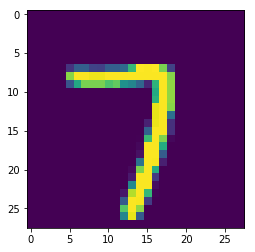

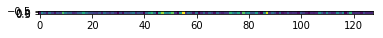

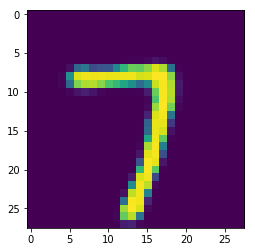

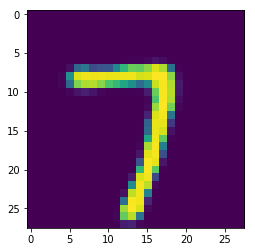

In [16]:
test_image=x_val[0].reshape(1,28,28,1)
plt.imshow(test_image.reshape(28, 28))
plt.show()
encoded_img=encoder.predict(test_image)
plt.imshow(encoded_img)
plt.show()
decoded_img=decoder.predict(encoded_img)
plt.imshow(decoded_img.reshape(28,28))
plt.show()
decoded_img2=autoencoder.predict(test_image)
plt.imshow(decoded_img2.reshape(28,28))
plt.show()

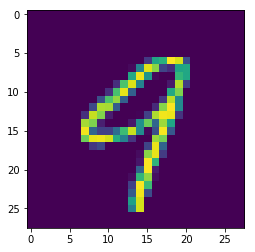

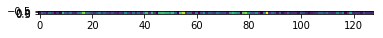

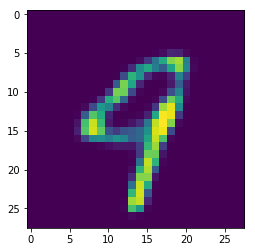

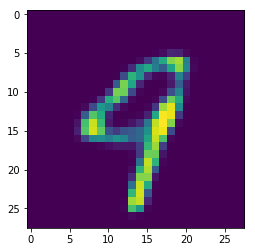

In [17]:
test_image=x_val[2].reshape(1,28,28,1)
plt.imshow(test_image.reshape(28, 28))
plt.show()
encoded_img=encoder.predict(test_image)
plt.imshow(encoded_img)
plt.show()
decoded_img=decoder.predict(encoded_img)
plt.imshow(decoded_img.reshape(28,28))
plt.show()
decoded_img2=autoencoder.predict(test_image)
plt.imshow(decoded_img2.reshape(28,28))
plt.show()

In [18]:
import numpy as np
def interpolate_points(p1, p2, n_steps=10):
	# interpolate ratios between the points
	ratios = np.linspace(0, 1, num=n_steps)
	# linear interpolate vectors
	vectors = list()
	for ratio in ratios:
		v = (1.0 - ratio) * p1 + ratio * p2
		vectors.append(v)
	return np.asarray(vectors)

In [19]:
# example of interpolating 
from numpy import asarray
from numpy import vstack
from numpy.random import randn
from numpy.random import randint
from numpy import arccos
from numpy import clip
from numpy import dot
from numpy import sin
from numpy import linspace
from numpy.linalg import norm
from keras.models import load_model
# # spherical linear interpolation (slerp)
# def slerp(val, low, high):
# 	omega = arccos(clip(dot(low/norm(low), high/norm(high)), -1, 1))
# 	so = sin(omega)
# 	if so == 0:
# 		# L'Hopital's rule/LERP
# 		return (1.0-val) * low + val * high
# 	return sin((1.0-val)*omega) / so * low + sin(val*omega) / so * high

# uniform interpolation between two points in latent space
def interpolate_points_slerp(p1, p2, n_steps=10):
	# interpolate ratios between the points
	ratios = linspace(0, 1, num=n_steps)
	# linear interpolate vectors
	vectors = list()
	for ratio in ratios:
		v = slerp(ratio, p1, p2)
		vectors.append(v)
	return asarray(vectors)

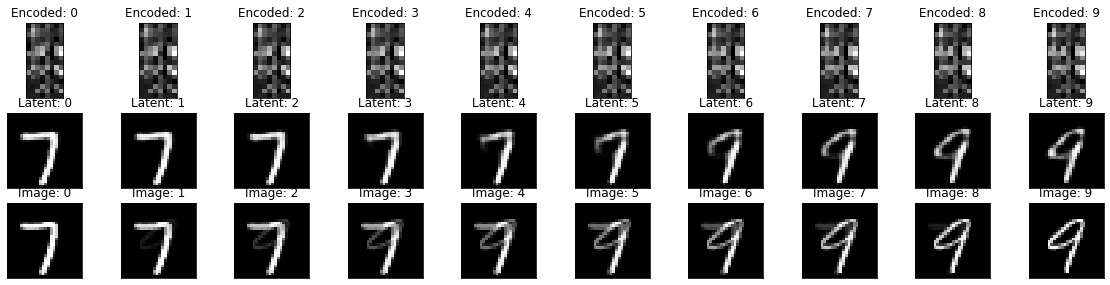

In [27]:
test_image1=x_val[0].reshape(1,28,28,1)
test_image2=x_val[2].reshape(1,28,28,1)
encoded_img1=encoder.predict(test_image1)
encoded_img2=encoder.predict(test_image2)
interpolated_images=interpolate_points(encoded_img1.flatten(),encoded_img2.flatten())
interpolated_orig_images=interpolate_points(test_image1.flatten(),test_image2.flatten())
# interpolated_slerp_images=interpolate_points_slerp(encoded_img1.flatten(),encoded_img2.flatten())
# interpolated_slerp_orig_images=interpolate_points_slerp(test_image1.flatten(),test_image2.flatten())

interpolated_images.shape
num_images = 10
np.random.seed(42)
plt.figure(figsize=(20, 8))

for i, image_idx in enumerate(interpolated_images):
    
    ax = plt.subplot(5, num_images, i + 1)
    plt.imshow(interpolated_images[i].reshape(16, 8))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax.set_title("Encoded: {}".format(i))
    
    ax = plt.subplot(5, num_images,num_images+ i + 1)
    plt.imshow(decoder.predict(interpolated_images[i].reshape(1,128)).reshape(28,28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax.set_title("Latent: {}".format(i))
    
#     ax.get_yaxis().set_visible(False)
#     ax = plt.subplot(5, num_images,2*num_images+ i + 1)
#     plt.imshow(decoder.predict(interpolated_slerp_images[i].reshape(1,128)).reshape(28,28))
#     plt.gray()
#     ax.get_xaxis().set_visible(False)
#     ax.get_yaxis().set_visible(False)
    
    ax = plt.subplot(5, num_images,2*num_images+ i + 1)
    plt.imshow(interpolated_orig_images[i].reshape(28,28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax.set_title("Image: {}".format(i))
    
#     ax = plt.subplot(5, num_images,4*num_images+ i + 1)
#     plt.imshow(interpolated_slerp_orig_images[i].reshape(28,28))
#     plt.gray()
#     ax.get_xaxis().set_visible(False)
#     ax.get_yaxis().set_visible(False)
plt.show()

In [ ]:
interpolated_images.shape

In [ ]:
encoder.save('encoder.h5')
decoder.save('decoder.h5')

<a href="./encoder.h5"> Encoder </a>

<a href="./decoder.h5"> Decoder </a>

In [ ]:
print("Done")

In [ ]:
# while True:
#     pass